In [7]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

### Load Spider Dataset

The official final Spider training data set combines train_spider.json and train_others.json. <br>
The databases used in train_others.json are from Restaurants, GeoQuery, Scholar, Academic, IMDB, and Yelp which are prepared by Finegan-Dollak et al., 2018. <br>
dev.json used for validation purpose. <br>
The Database and related table information is in tables.json

In [8]:
df = pd.read_json("./train_spider.json")
df_o = pd.read_json("./train_others.json")
df = df.append(df_o)
df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."


### Column Description:

question : User spoken question in Natural Language <br>
question_toks : Split User spoken question in Natural Language words <br>
db_id : The database Id or the database schema containing the Database Tables  <br>
query : the SQL query corresponding to the question. <br>
query_toks : Tokenized SQL Query <br> 
query_toks_no_value : Query with Masker Filter Condition Value <br>
sql : parsed results of the SQL query in a given syntax explained on https://github.com/taoyds/spider

In [9]:
print(
    "Database Schema : {}  \nQuery on Table head: {}".format(
        df["db_id"].values[0], df["query"].values[0]
    )
)
print(
    "Age Value '56' masked in 'query_toks_no_value' {}".format(
        df["query_toks_no_value"].values[0]
    )
)

Database Schema : department_management  
Query on Table head: SELECT count(*) FROM head WHERE age  >  56
Age Value '56' masked in 'query_toks_no_value' ['select', 'count', '(', '*', ')', 'from', 'head', 'where', 'age', '>', 'value']


No Null Values or Rows exist

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8659 entries, 0 to 1658
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   db_id                8659 non-null   object
 1   query                8659 non-null   object
 2   query_toks           8659 non-null   object
 3   query_toks_no_value  8659 non-null   object
 4   question             8659 non-null   object
 5   question_toks        8659 non-null   object
 6   sql                  8659 non-null   object
dtypes: object(7)
memory usage: 541.2+ KB


Why Spider is Cross Domain ?

In [11]:
db_schema = df["db_id"].unique()
print("Distinct Database existing in database : {}".format(len(db_schema)))
print("Sample Db Ids : {}".format(db_schema[:5]))

Distinct Database existing in database : 146
Sample Db Ids : ['department_management' 'farm' 'student_assessment' 'bike_1' 'book_2']


### Lets Have a Look at Data Examples 

Easy SQL Queries : Single Table Queries 

In [12]:
df2 = df[~df["query"].str.contains("join", case=False)]  # filter queries with join
df2 = df2[~df2["query"].str.contains("group by", case=False)]  # filter group by queries
df2 = df2[~df2["query"].str.contains("\)$", case=False)][
    "query"
]  # filter nested queries
df2.values[:2]

array(['SELECT count(*) FROM head WHERE age  >  56',
       'SELECT name ,  born_state ,  age FROM head ORDER BY age'],
      dtype=object)

In [13]:
# Filter on Query Column which does not contain word 'join'
print(
    "Number of Single Table Queries {} , Total Queries : {} ".format(
        df2.count(), len(df)
    )
)

Number of Single Table Queries 3530 , Total Queries : 8659 


Medium SQL Queries : Table with Joins

In [14]:
df2 = df[df["query"].str.contains("(join.*){2,}", case=False)]
df2 = df2[
    ~df2["query"].str.contains("group by", case=False)
]  # filter queries with group by
df2 = df2[~df2["query"].str.contains("intersect", case=False)]
df2["query"].values[:2]

array(["SELECT DISTINCT T1.creation FROM department AS T1 JOIN management AS T2 ON T1.department_id  =  T2.department_id JOIN head AS T3 ON T2.head_id  =  T3.head_id WHERE T3.born_state  =  'Alabama'",
       'SELECT T3.cell_mobile_number FROM candidates AS T1 JOIN candidate_assessments AS T2 ON T1.candidate_id = T2.candidate_id JOIN people AS T3 ON T1.candidate_id = T3.person_id WHERE T2.asessment_outcome_code = "Fail"'],
      dtype=object)

In [15]:
# Filter on Query Column which does not contain word 'join'
print(
    "Number of Table with Joins {} , Total Queries : {} ".format(
        df2["query"].count(), len(df)
    )
)

Number of Table with Joins 1188 , Total Queries : 8659 


Hard SQL Queries : Queries with  Joins , Having and Group By Clause

In [16]:
df2 = df[df["query"].str.contains("join .* group by .* having", case=False)]
df2["query"].values[:2]

array(['SELECT T1.department_id ,  T1.name ,  count(*) FROM management AS T2 JOIN department AS T1 ON T1.department_id  =  T2.department_id GROUP BY T1.department_id HAVING count(*)  >  1',
       'SELECT T1.Official_Name FROM city AS T1 JOIN farm_competition AS T2 ON T1.City_ID  =  T2.Host_city_ID GROUP BY T2.Host_city_ID HAVING COUNT(*)  >  1'],
      dtype=object)

In [17]:
print(
    "Number of Queries containing Group By and Having {} , Total Queries : {} ".format(
        df2["query"].count(), len(df)
    )
)

Number of Queries containing Group By and Having 243 , Total Queries : 8659 


Extra Hard SQL Queries : Nested Queries

In [18]:
df2 = df[df["query"].str.contains("\)$", case=False)]
df2["query"].values[:2]

array(['SELECT Official_Name FROM city WHERE City_ID NOT IN (SELECT Host_city_ID FROM farm_competition)',
       'SELECT Official_Name FROM city WHERE City_ID NOT IN (SELECT Host_city_ID FROM farm_competition)'],
      dtype=object)

In [19]:
print(
    "Number of Nested Queries , Total Queries : {} ".format(
        df2["query"].count(), len(df)
    )
)

Number of Nested Queries , Total Queries : 504 


## Data Pre-Processing

In [25]:
data = pd.DataFrame(columns=["text", "SQL"])

In [26]:
data[["SQL", "text"]] = df[["query_toks", "question_toks"]]

In [31]:
text = data.text.values
sql = data.SQL.values

In [49]:
def unique_word_count(list_of_sentences):
    """
    Parameters
    ------------
    list_of_sentences : input a list of sentences
    Returns
    ------------
    Unique Word count
    """
    word_list = []
    for sentence in list_of_sentences:
        for word in sentence:
            word = word.lower().strip()
            if word not in word_list:
                word_list.append(word)
    return len(word_list)

In [51]:
print("Unique words in Text Vocabulary:", unique_word_count(text))
print("Unique words in SQL::", unique_word_count(sql))

Unique words in Text Vocabulary: 3974
Unique words in SQL:: 5583


In [53]:
def word_mapping(list_of_sentences):
    word2index = {}
    index2word = {}
    word_freq = {}
    n_words = 0
    for sentence in list_of_sentences:
        for word in sentence:
            word = word.lower().strip()
            if word not in word2index:
                word2index[word] = n_words
                index2word[n_words] = word
                word_freq[word] = 1
                n_words += 1
            else:
                word_freq[word] += 1
    return word2index, index2word, word_freq

In [55]:
word2index, index2word, word_freq = word_mapping(text)

In [79]:
import pandas as pd

word_freq_dict = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
word_frq_df = pd.DataFrame(word_freq_dict.items(), columns=["word", "freq"])

<AxesSubplot:xlabel='freq', ylabel='word'>

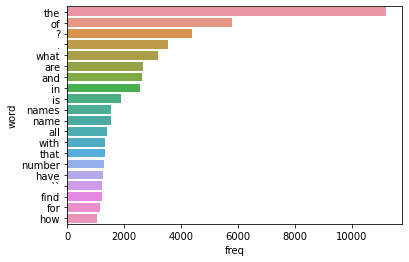

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x="freq", y="word", data=word_frq_df.head(20))
# plt.savefig('plot.png', dpi=1200,orientation="horizontal")

In [114]:
print("Mapping Words to Unique Index :", list(word2index.items())[:4])
print("Mapping Index to Word :", list(index2word.items())[:4])

Mapping Words to Unique Index : [('how', 0), ('many', 1), ('heads', 2), ('of', 3)]
Mapping Index to Word : [(0, 'how'), (1, 'many'), (2, 'heads'), (3, 'of')]


## Split Dataset for Training and Test
Select 2100 SQL samples from train_spider.json and 900 samples from dev.json

In [116]:
test = pd.read_json("./dev.json")
train = pd.read_json("./train_spider.json")

In [121]:
train_subset = train.iloc[:2100, :]
test_subset = test.iloc[:900, :]
print(train_subset.shape)
print(test_subset.shape)

(2100, 7)
(900, 7)
